# Calculating Rt Covid-19

In [ ]:
The rate at which a virus is transmitted — known as the R-naught (Ro), or basic reproductive number — refers to the average 
number of people to whom an infected person passes on the virus in a population with no pre-existing immunity. The Ro can vary
from place to place because of the population’s age structure and how frequently people come into contact with each other.
The “effective” version of that number, the Rt is the virus’s actual transmission rate at a given time t.  As a pandemic evolves,Rt varies according to control measures and loosening/tightening of restrictions.When 𝑅≫1 , the pandemic will spread quickly through a large part of the population. If 𝑅𝑡<1 , the pandemic will slow quickly before it has a chance to infect many people. If Rt=1, the number of infected people stays steady over time; the situation stays the sam.e The lower the 𝑅𝑡 : the more manageable the situation. In general, any 𝑅𝑡<1 means things are under control.

Here we examine the Rt problem at the state level. A Bayesian approach (Bettencourt & Ribeiro 2008) is used, except here process model with Gaussian noise is used to estimate a time-varying 𝑅𝑡 rather than static 𝑅𝑡.


In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = ['AS', 'GU', 'PR', 'VI', 'MP']

%config InlineBackend.figure_format = 'retina'

We use Bayes' Theorem:

𝑃(𝑅𝑡|𝑘)=𝑃(𝑘|𝑅𝑡)⋅𝑃(𝑅𝑡)𝑃(𝑘)
 
 having seen  𝑘  new cases, we believe the distribution of  𝑅𝑡  is equal to:

The likelihood of seeing  𝑘  new cases given  𝑅𝑡  times ...
The prior beliefs of the value of  𝑃(𝑅𝑡)  without the data ...
divided by the probability of seeing this many cases in general.
(single day)

We make it iterative: every day that passes, use yesterday's prior  𝑃(𝑅𝑡−1)  to estimate today's prior  𝑃(𝑅𝑡) . 
    We will assume the distribution of  𝑅𝑡  to be a Gaussian centered around  𝑅𝑡−1 , 
    sigma is a hyperparameter we can estimate. 
    

 Likelihood Function  𝑃(𝑘𝑡|𝑅𝑡) 
A likelihood function function says how likely we are to see  𝑘  new cases, given a value of  𝑅𝑡 .

we can use the Poisson Distribution. Given an average arrival rate of  𝜆  new cases per day, the probability of seeing
𝑘  new cases is distributed according to the Poisson distribution:

𝑃(𝑘|𝜆)=𝜆𝑘𝑒−𝜆𝑘!

In [3]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


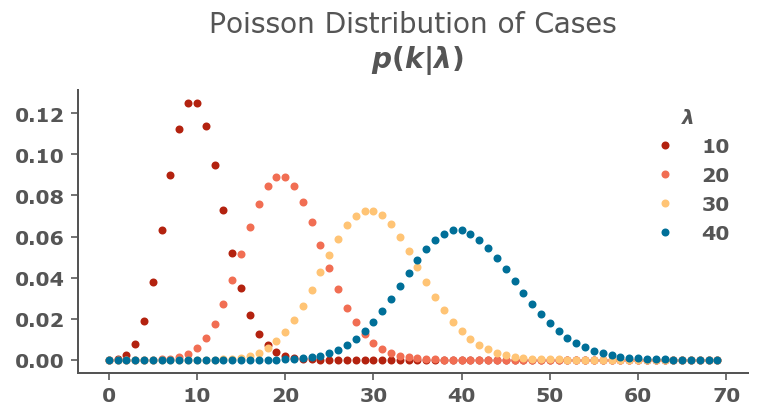

In [4]:
fig, ax = plt.subplots(figsize=(12,5))

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

Here, we know there have been  𝑘  cases and we need to know what value of  𝜆  is most likely. In order to do this, 
we fix  𝑘  in place while varying  𝜆 . This is the likelihood function.  For example, imagine we observe  𝑘=25  new cases, 
and we want to know how likely each  𝜆  is:

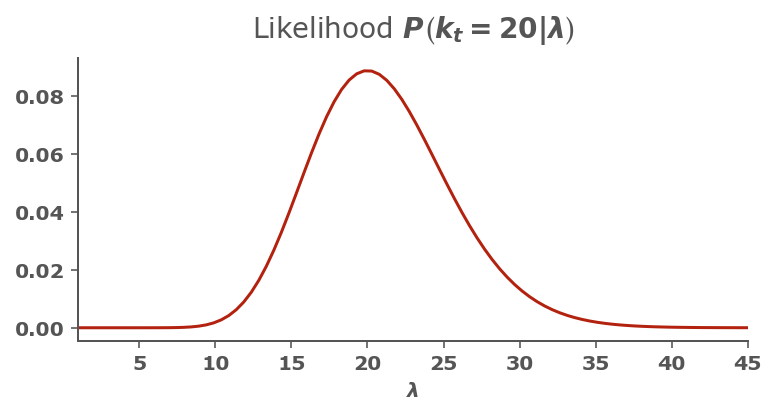

In [4]:
k = 25

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=25|\lambda\right)$', figsize=(12,5));

But in our case, we know there have been  𝑘  cases and we need to know what value of  𝜆  is most likely. In order to do this,
we fix  𝑘  in place while varying  𝜆 . This is called the likelihood function.

For example, imagine we observe  𝑘=25  new cases, and we want to know how likely each  𝜆  is:

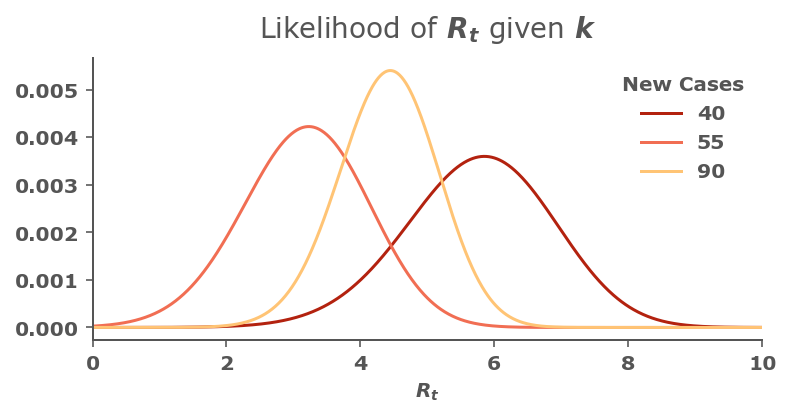

In [5]:
k = np.array([15, 25, 35, 45, 55, 60])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval #serial intervial ~7
GAMMA = 1/7

# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10),
    figsize=(6,2.5)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

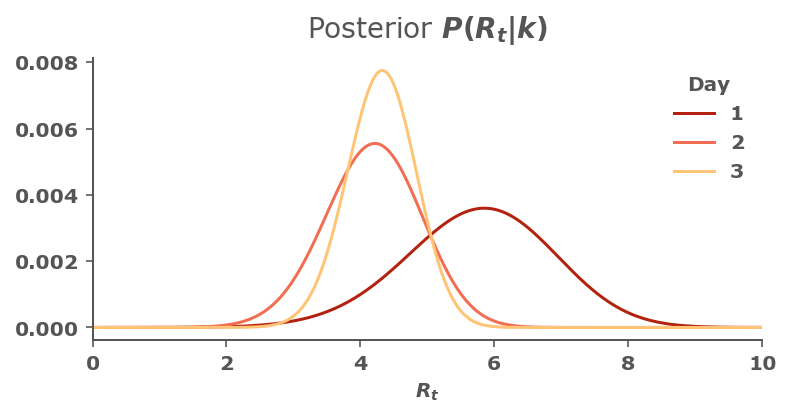

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [7]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

In [8]:
def highest_density_interval(pmf, p=.9, debug=False):
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


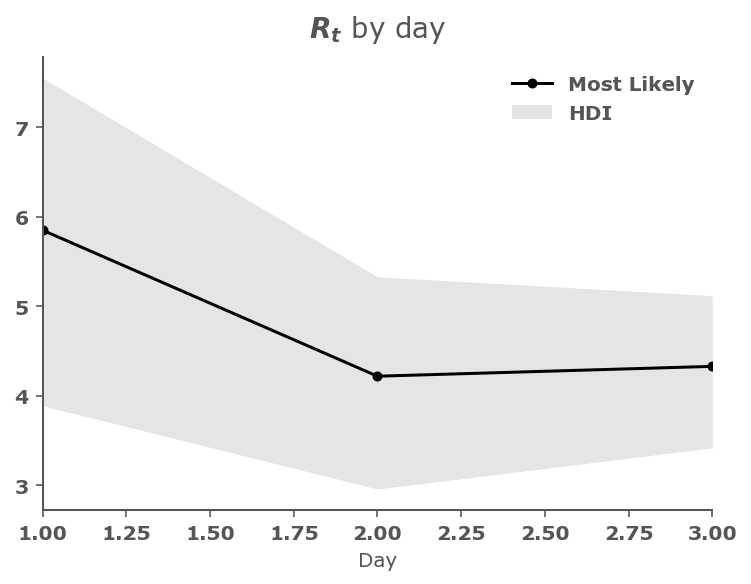

In [9]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

# MAINE DATA-- CALCULATE R

In [10]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

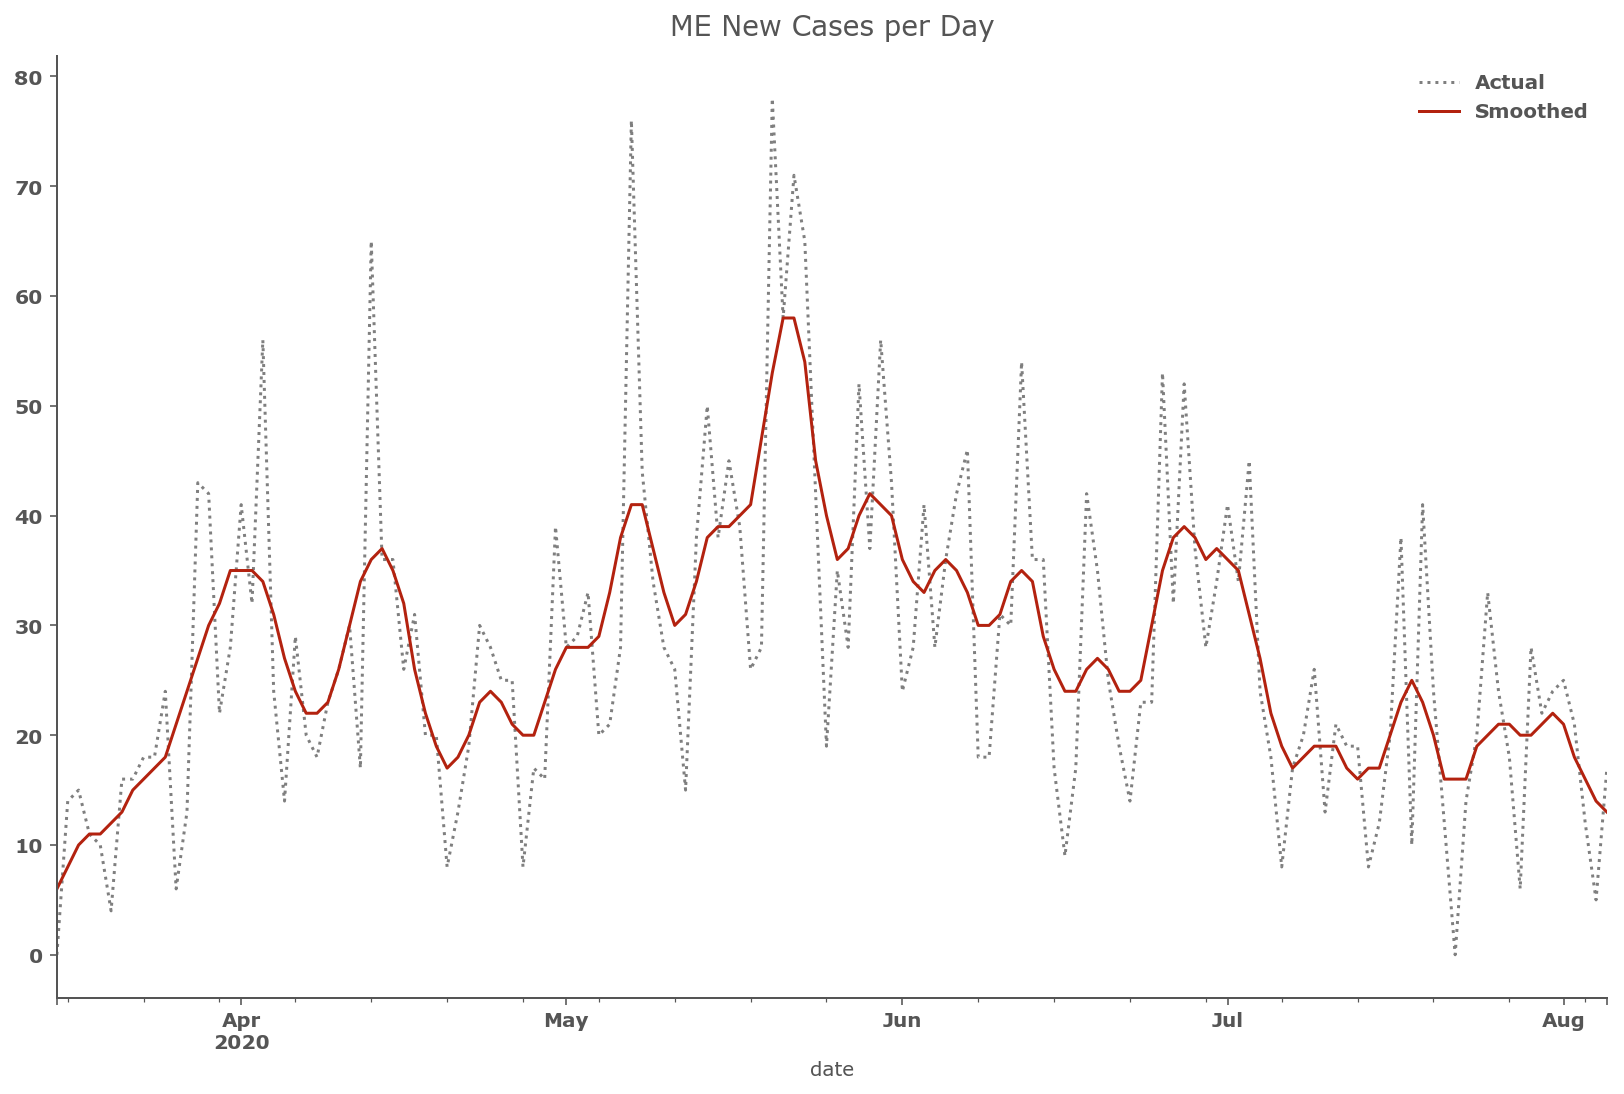

In [11]:
state_name = 'ME'

def prepare_cases(cases, cutoff=5):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(1000/72, 600/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

Function for Calculating the Posteriors---
To calculate the posteriors we follow these steps:
Calculate the expected arrival rate for every day's Poisson process
Calculate each day's likelihood distribution over all possible values of Rt
Calculate the process matrix based on the value of  we discussed above
Calculate our initial prior because our first day does not have a previous day from which to take the posterior
Based on info from the cdc we will choose a Gamma with mean 7.
Loop from day 1 to the end, doing the following:
Calculate the prior by applying the Gaussian to yesterday's prior. 
Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
Divide by the probability of the data (also Bayes' rule)

In [12]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keeping track of the sum of the log of the probability of data for max liklihood calc.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# assigning sigma value for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

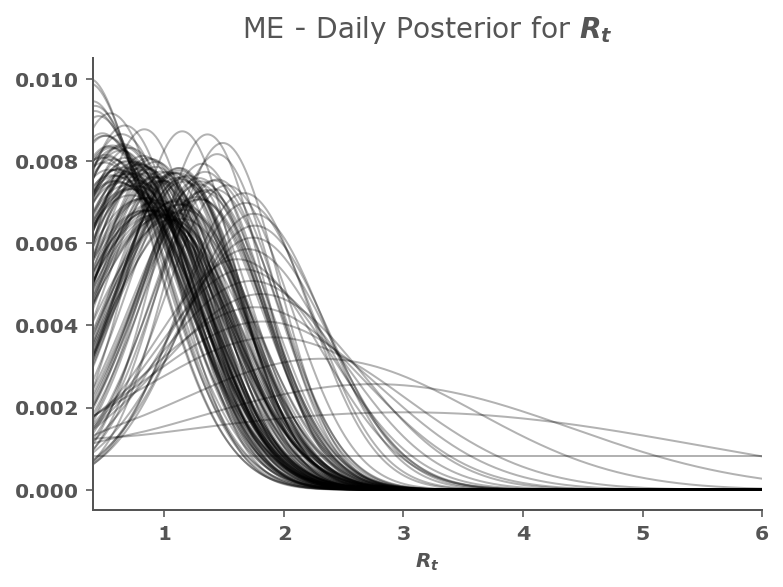

In [13]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [14]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-08-01,0.92,0.02,1.75
2020-08-02,0.72,0.00,1.59
2020-08-03,0.59,0.00,1.52
2020-08-04,0.50,0.00,1.46
2020-08-05,0.48,0.00,1.46


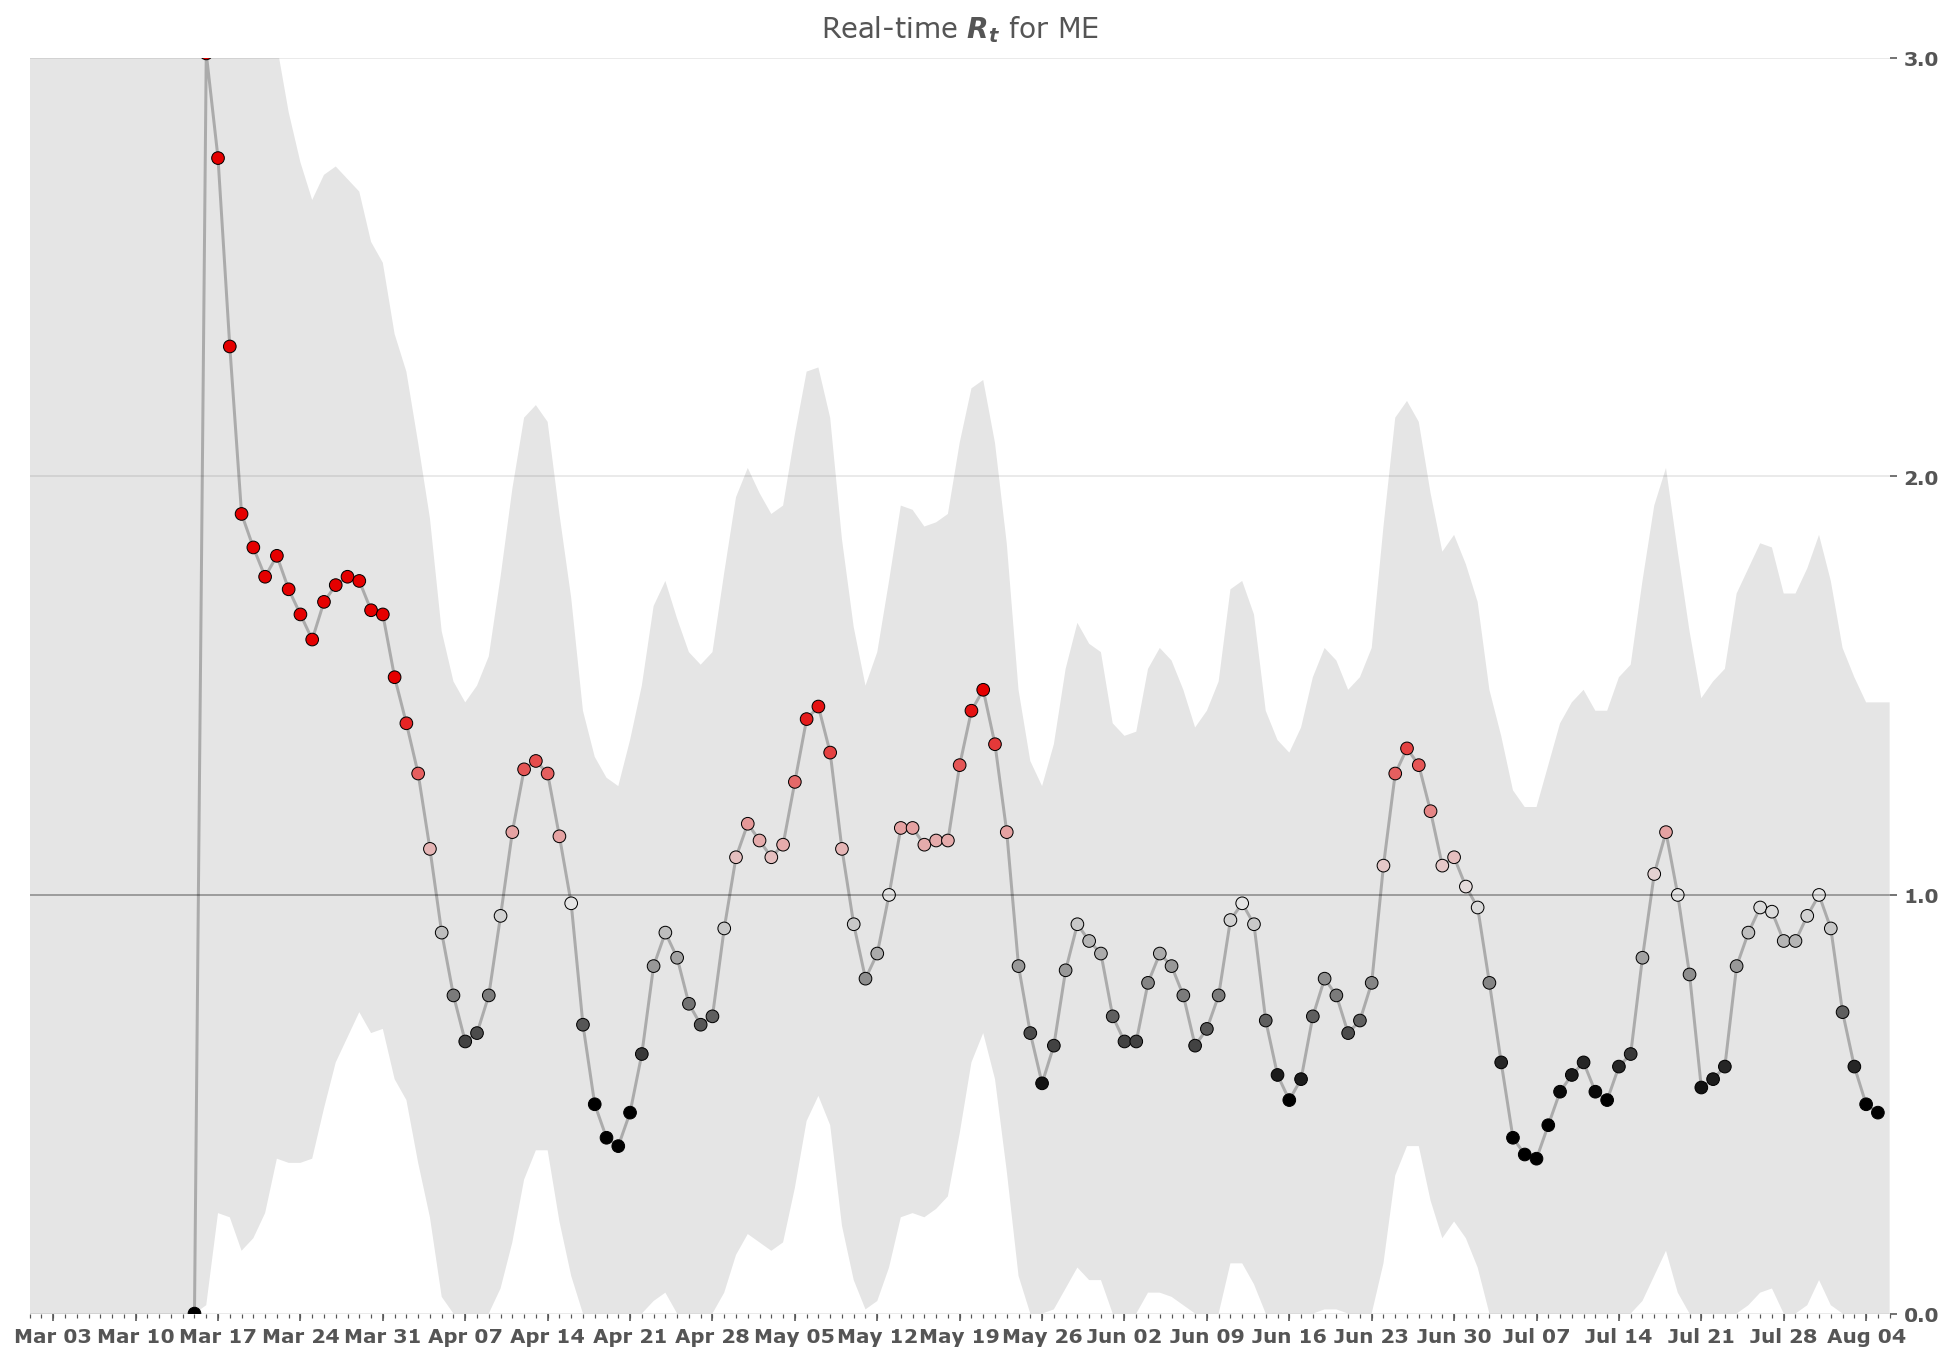

In [15]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(1200/72,800/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [16]:
states.loc[('ME', pd.Timestamp('2020-07-28'))] = 3838

In [17]:
states.xs('ME').diff().tail()

date
2020-08-01    25.0
2020-08-02    21.0
2020-08-03    12.0
2020-08-04     5.0
2020-08-05    17.0
Name: positive, dtype: float64

In [18]:
sigmas = np.linspace(1/20, 1, 20)

targets = ~states.index.get_level_values('state').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]

results = {}

for state_name, cases in states_to_process.groupby(level='state'):
    
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=25)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=10)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

VT


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [ ]:
final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

In [ ]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result.iloc[1:], axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

In [ ]:
# Since we now use a uniform prior, the first datapoint is pretty bogus, so just truncating it here
final_results = final_results.groupby('state').apply(lambda x: x.iloc[1:].droplevel(0))

In [ ]:
final_results.to_csv('data/rt_old.csv')